# Final figures

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
DATA_DIR = Path("/lustre/groups/ml01/workspace/louis.kuemmerle/projects/G1/data/processed_rev")
RES_DIR = "/lustre/groups/ml01/workspace/louis.kuemmerle/projects/G1/results/spapros_smk_res"

In [3]:
df_eval = pd.read_csv(Path(RES_DIR, "evaluation_overview.csv"),index_col=0)
df_data = pd.read_csv(Path(RES_DIR, "data_parameters.csv"),index_col=0)
df_sele = pd.read_csv(Path(RES_DIR, "selection_overview.csv"),index_col=0).set_index("selection_name")

In [4]:

#n = 50
##############

eval_experiment_to_batch = {
    "sn":"eval_batch6.1",
    "merfish":"eval_batch6.2.1",
    "merfish fine ct":"eval_batch6.2.2",
}

selection_experiment_to_batch = {
    "sn":"batch6.1",
    "merfish":"batch6.2.1",
    "merfish fine ct":"batch6.2.2",
}

experiment_to_eval_data_id = {
    exp:df_eval.loc[df_eval["eval_batch"] == batch,"eval_data_id"].unique()[0] for exp, batch in eval_experiment_to_batch.items()
}
experiment_to_eval_dataset = {
    exp:df_eval.loc[df_eval["eval_batch"] == batch,"eval_dataset"].unique()[0] for exp, batch in eval_experiment_to_batch.items()
}


## Generate plot df (no need to rerun, saved at the end)

#### Load metrics and infos of selections

In [5]:
df_sn = pd.read_csv(Path(RES_DIR, f"evaluation/{experiment_to_eval_dataset['sn']}_{experiment_to_eval_data_id['sn']}_summary.csv"), index_col=0)
df_sp = pd.read_csv(Path(RES_DIR, f"evaluation/{experiment_to_eval_dataset['merfish']}_{experiment_to_eval_data_id['merfish']}_summary.csv"), index_col=0)

In [6]:
for df in [df_sn, df_sp]:
    #df["method"] = df.index.to_series().apply(
    #    lambda x: x.split("_")[0])
    df["ct score"] = (
        df['forest_clfs accuracy'] + df['forest_clfs perct acc > 0.8']) / 2
    df["var score"] = (
        df['knn_overlap mean_overlap_AUC'] +
        df['cluster_similarity nmi_5_20'] +
        + df['cluster_similarity nmi_21_60']
    ) / 3
    df["score"] = (
        df["ct score"] + df["var score"]) / 2

df_sn = df_sn.rename(columns={col:f"(sn) {col}" for col in df_sn.columns})
df_sp = df_sp.rename(columns={col:f"(sp) {col}" for col in df_sp.columns})

In [7]:
# # get index overlap between sn and sp
# idx_overlap = df_sn.index.intersection(df_sp.index)

# Concatenate sn and sp on shared index
df = pd.concat([df_sn, df_sp], axis=1, join="inner")
df["method"] = df.index.to_series().apply(lambda x: x.split("_")[0])
df = df.loc[~df.isna().any(axis=1)]
df["n"] = df_sele.loc[df.index,"n"].values
df["modality"] = df_sele.loc[df.index,"dataset"].apply(lambda d: "sp" if ("merfish" in d) else "sn")


#### Add spatial variation stats

In [8]:
import scanpy as sc
import squidpy as sq

In [53]:
# Load data
print("Load data")
data_id = experiment_to_eval_data_id["merfish"]
adata = sc.read(
    DATA_DIR / f"tmp_data/{df_data.loc[data_id,'dataset']}_{data_id}.h5ad"
)
var_cols = [c for c in adata.var.columns if c not in adata.var_names]
adata.var = adata.var[var_cols]


# Set correct spatial coordinates (initial adata.obsm['spatial'] is wrong)
#adata.obsm['spatial_coords'] = adata.obsm['spatial'].copy() # actually not needed 
print("Set coordinates")
adata.obsm['spatial'] = adata.obs[['adjusted.y','adjusted.x']].values.copy()

adata.obsm['spatial'][:,0] -= np.min(adata.obs[['adjusted.y','adjusted.x']].values[:,0])
adata.obsm['spatial'][:,1] -= np.min(adata.obs[['adjusted.y','adjusted.x']].values[:,1])


# Get statistics
print("Get stats")
sq.gr.spatial_neighbors(adata, key_added='spatial')
sq.gr.spatial_autocorr(adata, mode="moran")
sq.gr.spatial_autocorr(adata, mode="geary")

celltypes = adata.obs["clean_type"].unique().tolist()
for ct in celltypes:
    a = adata[adata.obs["clean_type"] == ct].copy()
    sq.gr.spatial_neighbors(a, key_added='spatial')
    sq.gr.spatial_autocorr(a, mode="moran")
    #sq.gr.spatial_autocorr(a, mode="geary")    
    adata.uns["moranI"]["I_"+ct] = a.uns["moranI"]["I"].values
    #adata.uns["gearyC", "C_"+ct] = a.uns["gearyC","C"].values

adata.uns["moranI"]["I ct max"] = adata.uns["moranI"][[f"I_{ct}" for ct in celltypes]].max(axis=1)
adata.uns["moranI"]["I ct mean"] = adata.uns["moranI"][[f"I_{ct}" for ct in celltypes]].mean(axis=1)


# Get score for each gene set:
print("Calc gene scores")
df_moran = pd.DataFrame(index=df.index, columns=["moranI_sum","moranI_mean"], dtype='float64')

for i,selection in enumerate(df.index): 
    if (not (i % 100)) or (i == (len(df)-1)):
        print(i+1,"/",len(df))
    if Path(RES_DIR, "selection", selection+".csv").exists():
        tmp_df = pd.read_csv(Path(RES_DIR, "selection", selection+".csv"),index_col=0)
    else:
        print(Path(RES_DIR, "selection", selection+".csv"), " does not exist!")
        continue
    genes = tmp_df.loc[tmp_df.iloc[:,0]].index.tolist()
    if np.all([g in adata.var_names for g in genes]):
        df_moran.loc[selection,"moranI_sum"] = adata.uns["moranI"].loc[genes,"I"].sum()
        df_moran.loc[selection,"moranI_mean"] = adata.uns["moranI"].loc[genes,"I"].mean()
        df_moran.loc[selection,"gearyC_sum"] = adata.uns["gearyC"].loc[genes,"C"].sum()
        df_moran.loc[selection,"gearyC_mean"] = adata.uns["gearyC"].loc[genes,"C"].mean()
        df_moran.loc[selection,"moranI_ct_max_mean"] = adata.uns["moranI"].loc[genes,"I ct max"].mean()
        df_moran.loc[selection,"moranI_ct_mean_mean"] = adata.uns["moranI"].loc[genes,"I ct mean"].mean()

# Save metric in df
df["(sp) moranI"] = df_moran["moranI_mean"].values
df["(sp) moranI ct max"] = df_moran["moranI_ct_max_mean"].values
df["(sp) moranI ct mean"] = df_moran["moranI_ct_mean_mean"].values

In [20]:
df = df.loc[~df["(sp) moranI"].isnull()]

#### Save plot df

In [23]:
df.to_csv(Path(RES_DIR,"plot_tables","metrics_sn_and_merfish_bootstrap.csv"))

## Plots
- scatter plots for sn vs sp: ct score, var score, score
- scatter plots scores vs moranI

In [24]:
df = pd.read_csv(Path(RES_DIR,"plot_tables","metrics_sn_and_merfish_bootstrap.csv"),index_col=0)

In [25]:
metric_to_label = {
    'score'                         :'score',
    'var score'                     :'variation recovery score',
    'cluster_similarity nmi_5_20'   :'coarse clustering similarity',
    'cluster_similarity nmi_21_60'  :'fine clustering similarity',
    'knn_overlap mean_overlap_AUC'  :'neighborhood similarity',
    'ct score'                      :'cell type classif. score',
    'forest_clfs accuracy'          :'cell type classif. acc.',
    'forest_clfs perct acc > 0.8'   :'perct. of captured cell types',
    'moranI'                        :"spatial variation (Moran's I)",
    'moranI ct max'                 :'within cell type spatial variation',
    #'moranI ct mean'                :'',
}

metric_to_label_n = {
    'score'                         :'score',
    'var score'                     :'variation\nrecovery score',
    'cluster_similarity nmi_5_20'   :'coarse clustering\nsimilarity',
    'cluster_similarity nmi_21_60'  :'fine clustering\nsimilarity',
    'knn_overlap mean_overlap_AUC'  :'neighborhood\nsimilarity',
    'ct score'                      :'cell type\nclassif. score',
    'forest_clfs accuracy'          :'cell type\nclassif. acc.',
    'forest_clfs perct acc > 0.8'   :'perct. of captured\ncell types',
    'moranI'                        :"spatial variation\n(Moran's I)",
    'moranI ct max'                 :'within cell type\nspatial variation',
    #'moranI ct mean'                :'',
}


from matplotlib import rcParams
from matplotlib import colors

plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300
SMALL_SIZE =   9  #17
MEDIUM_SIZE = 11  #19
BIGGER_SIZE = 13  #21
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Dissociated metrics

In [41]:
# scatter plot
markers = {
    'spapros': 'D',   # Diamond
    'spaproscto': 's',   # Square
    'genebasis': 'd', # Thin diamond
    'scmer': '^',   # Triangle up
    'selfe': 'v',   # Triangle down
    'nsforest': '<',   # Triangle left
    'smash': '>',   # Triangle right
    'cosg': 'p',   # Pentagon
    'scgenefit': '*',   # Star
    'triku': 'H',   # Hexagon
    'scpnmf': 'P',   # Plus
    'DE': 'o',   # Circle
    'pca': 'o',   # Circle
    'persist': 'X', # Cross
    'persistus': 'X', # Cross
}

#"#e6194b", "#3cb44b", "#4363d8", "#f58231"

colors = {
    'spapros'    : "#3cb44b",#'green',
    'spaproscto' : "#3cb44b",#'green',
    'genebasis'  : "#4363d8",#'blue',
    'scmer'      : "#4363d8",#'blue',
    'selfe'      : "#4363d8",#'blue',
    'pca'        : "#4363d8",#'blue',
    'scpnmf'     : "#4363d8",#'blue',
    'persistus'  : "#4363d8",#'blue',
    'persist'    : "#e6194b",#'red',
    'nsforest'   : "#e6194b",#'red',
    'DE'         : "#e6194b",#'red',
    'scgenefit'  : "#e6194b",#'red',
    'smash'      : "#f58231",#'orange',
    'cosg'       : "#f58231",#'orange',
    'triku'      : "#f58231",#'orange',
}

#### scatter plots sn vs spatial

In [42]:
def get_plot_df(df, metric_x, metric_y):
    """
    """
    methods = df['method'].unique().tolist()
    data = {
        'method' : methods,
        'x_mean' : df.groupby("method")[metric_x].mean().loc[methods],
        'y_mean' : df.groupby("method")[metric_y].mean().loc[methods],
        'x_std'  : df.groupby("method")[metric_x].std().loc[methods],
        'y_std'  : df.groupby("method")[metric_y].std().loc[methods],
    }
    return pd.DataFrame(data)

Correlation all points: 
0.6302468462067279
Correlation of means: 
0.6653708437890069


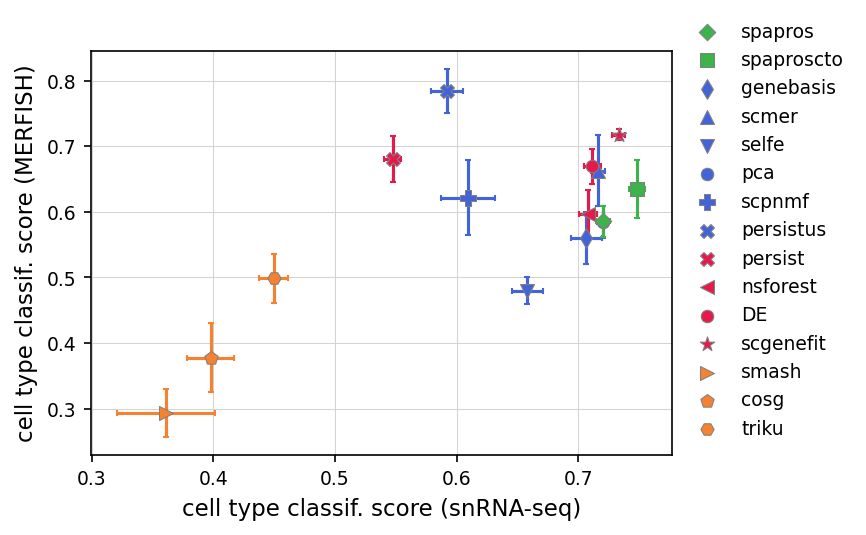

Correlation all points: 
0.6234808679303921
Correlation of means: 
0.678890396847956


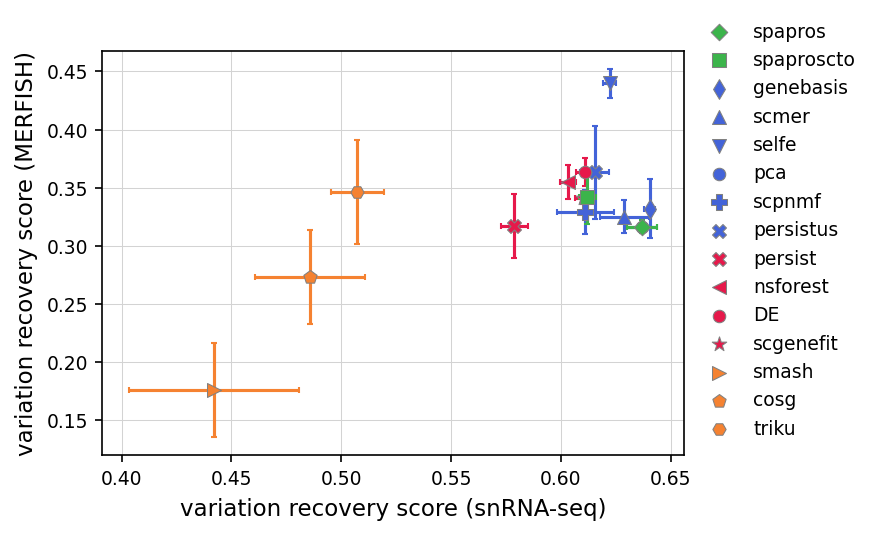

Correlation all points: 
0.7135790190462796
Correlation of means: 
0.7544114352616778


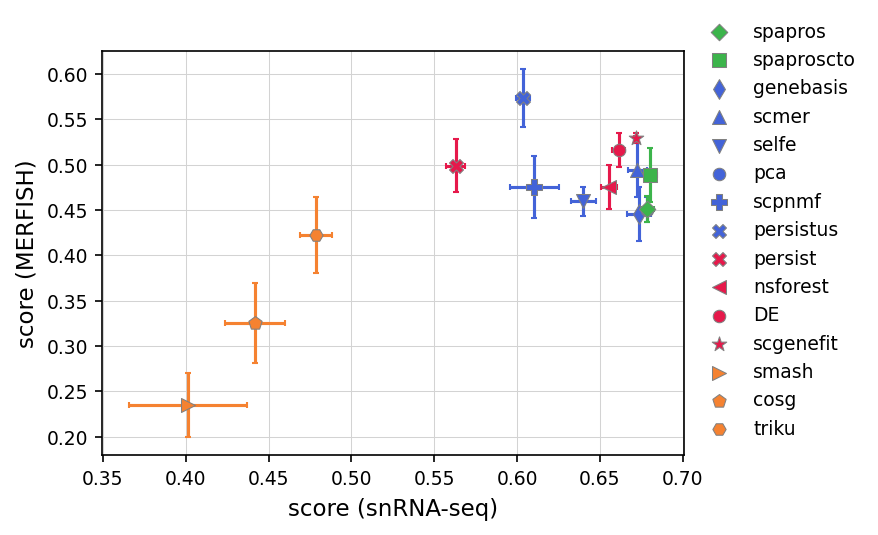

Correlation all points: 
0.7511370782676391
Correlation of means: 
0.7918641008165125


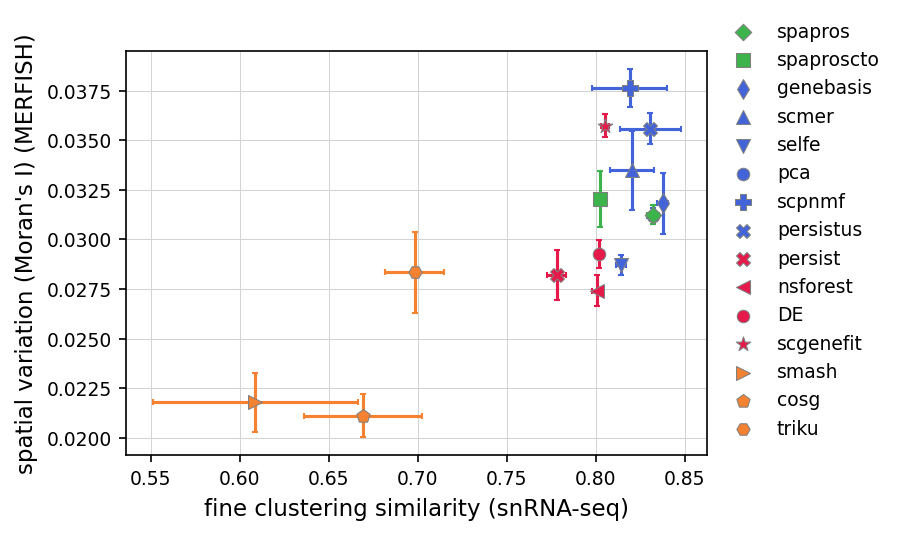

In [52]:
m = "sn" # only take into account selections on modality `m`
n = 150 # 
metric_pairs = [
    ["ct score", "ct score"],
    ["var score", "var score"],
    ["score", "score"],
    ["cluster_similarity nmi_21_60", "moranI"],
]

S = 45
marker_to_size = {
    'D' : S * 0.7, # Diamond
    's' : S * 0.9, # Square
    'd' : S, # Thin diamond
    '^' : S, # Triangle up
    'v' : S, # Triangle down
    '<' : S, # Triangle left
    '>' : S, # Triangle right
    'p' : S, # Pentagon
    '*' : S * 1.2, # Star
    'H' : S * 0.9, # Hexagon
    'P' : S * 1.4, # Plus
    'X' : S, # Cross
    'o' : S*0.8, # Circle
    '8' : S, # Circle
}




for (m1,m2) in metric_pairs:
    #print(f"########## selection on {m}, {n} selected genes ##########")
    
    fig = plt.figure(figsize=(5,3.5))#(7,5))
    
    # Subset to number of genes and modality
    df_ = df.loc[(df["n"]==n) & (df["modality"]==m)].copy()
    print("Correlation all points: ")
    print(df_[f"(sn) {m1}"].corr(df_[f"(sp) {m2}"]))
    #print(np.corrcoef(df_[f"(sn) {m1}"], df_[f"(sp) {m2}"])[0,1])
    
    df_ = get_plot_df(df_, f"(sn) {m1}", f"(sp) {m2}")
    # Get correlation
    print("Correlation of means: ")
    print(df_["x_mean"].corr(df_["y_mean"]))
    corr = df_["x_mean"].corr(df_["y_mean"])
    #print(np.corrcoef(df_["x_mean"], df_["y_mean"])[0,1])
    
    
    for method in df["method"].unique()[::-1]:
        #df_tmp = df_.loc[(df_["method"]==method)]
        #plt.scatter(df_tmp[f"(sn) {m1}"], df_tmp[f"(sp) {m2}"], color=colors[method], marker=markers[method], label=method, s=15)#30)
        row = df_.loc[method]
        plt.errorbar(row['x_mean'], row['y_mean'], xerr=row['x_std'], yerr=row['y_std'], color=colors[method], capsize=1.5, zorder=2)
        plt.scatter(
            df_.loc[method,f"x_mean"], df_.loc[method,f"y_mean"], color=colors[method], 
            marker=markers[method], label=method, s=marker_to_size[markers[method]],#45, 
            linewidths=0.5, edgecolors="gray", zorder=3
        )

    plt.xlabel(metric_to_label[m1] + " (snRNA-seq)") #f"(sn) {m1}") 
    plt.ylabel(metric_to_label[m2] + " (MERFISH)") #f"(sp) {m2}") 

    handles, labels = plt.gca().get_legend_handles_labels()
    handles = [handles[labels.index(method)] for method in colors]
    labels = list(colors.keys())
    plt.legend(handles, labels,frameon=False, loc="lower left", bbox_to_anchor=(1,0))
    #fig.savefig(f"figures/1_1_scatterplot_sn_vs_sp_{m1}_r{np.round(corr)}.png", bbox_inches = "tight", transparent=True)
    fig.savefig(f"figures/1_1_scatterplot_sn_vs_sp_{m1}_r{np.round(corr,2)}.pdf", bbox_inches = "tight", transparent=True)
    plt.grid(color='lightgray', linestyle='-', linewidth=0.5, zorder=1)
    plt.show()